In [1]:
import comet_ml
from comet_ml.query import Parameter
import pandas as pd
import numpy as np

comet_api = comet_ml.api.API()

def get_exps(strat):
    query = (Parameter('SERVER_OPT') == 'Adam') & (Parameter('CLIENT_OPT') == 'Adam') & (Parameter('CLIENT_OPT_STRATEGY') == strat)
    return comet_api.query('federated-learning', 'both-side-opt', query)

def get_df(exps):
    def get_list(t, c):
        res = []
        for exp in exps:
            response = c(exp)
            if isinstance(response, list):
                res.append(None)
            else:
                res.append(t(response['valueMax']))
        return res
    def get_params(t, n):
        return get_list(t, lambda exp: exp.get_parameters_summary(n))
    def get_metrics(t, n):
        return get_list(t, lambda exp: exp.get_metrics_summary(n))

    ids = [exp.id for exp in exps]

    c_lr = get_params(float, 'CLIENT_LEARNING_RATE')
    s_lr = get_params(float, 'SERVER_LEARNING_RATE')

    last100_avg_acc = get_metrics(float, 'last100_avg_acc')
    teas = get_metrics(float, 'test_acc')
    return pd.DataFrame({'id': ids, 
                         'test_acc': teas, 
                         'last100_avg_acc': last100_avg_acc, 
                         'c_lr': c_lr, 
                         's_lr': s_lr,
                            })
exps = get_exps('nothing')
df = get_df(exps)

In [2]:
c_lr = 0.01
s_lr = 0.01
res = df[(df.c_lr == c_lr) & (df.s_lr == s_lr)].last100_avg_acc
len(res)
res.iloc[0]

12.0712

In [3]:
def get_real_acc(df, c_lr, s_lr, field='last100_avg_acc'):
    res = df[(abs(df.c_lr - c_lr) < 1e-15) & (abs(df.s_lr - s_lr) < 1e-15)]
#     print(res)
    res = res[field]
    if len(res) == 0:
        return -1
    elif len(res) == 1:
        return res.iloc[0]
    else:
        print(len(res))
        print(df[(abs(df.c_lr - c_lr) < 1e-15) & (abs(df.s_lr - s_lr) < 1e-15)])

In [4]:
class DataBase:
    def __init__(self):
        self.df = pd.DataFrame(columns=['c_lr', 's_lr', 'acc'])
    
    def get_max(self):
        max_series = self.df.iloc[self.df.acc.idxmax()]
        return max_series.acc
    
    def get_next(self):
        max_series = self.df.iloc[self.df.acc.idxmax()]
        max_c_lr = max_series.c_lr
        max_s_lr = max_series.s_lr
        mult = [1/10, 1, 10]
        for s_lr_m in mult:
            for c_lr_m in mult:
                c_lr = max_c_lr*c_lr_m
                s_lr = max_s_lr*s_lr_m
                if self.get(c_lr, s_lr) == -1:
                    return c_lr, s_lr
        return None, None
        
    def get(self, c_lr, s_lr):
        return get_real_acc(self.df, c_lr, s_lr, 'acc')
    
    def train(self, c_lr, s_lr):
        acc = get_real_acc(df, c_lr, s_lr)
        self.df = self.df.append({'c_lr': c_lr, 's_lr': s_lr, 'acc': acc}, ignore_index=True)

In [31]:
class DataBase:
    def __init__(self):
        self.df = pd.DataFrame(columns=['c_lr', 's_lr', 'acc'])
        
    def __iter__(self):
        return self
    
    def __next__(self):
        max_series = self.df.iloc[self.df.acc.idxmax()]
        max_c_lr = max_series.c_lr
        max_s_lr = max_series.s_lr
        mult = [1/10, 1, 10]
        for s_lr_m in mult:
            for c_lr_m in mult:
                c_lr = max_c_lr*c_lr_m
                s_lr = max_s_lr*s_lr_m
                if self.get(c_lr, s_lr) == -1:
                    return c_lr, s_lr
        raise StopIteration
        
    def get(self, c_lr, s_lr):
        return get_real_acc(self.df, c_lr, s_lr, 'acc')
    
    def train(self, c_lr, s_lr):
        acc = get_real_acc(df, c_lr, s_lr)
        self.df = self.df.append({'c_lr': c_lr, 's_lr': s_lr, 'acc': acc}, ignore_index=True)

In [32]:
c_lr = 0.0001
s_lr = 0.01
db = DataBase()
db.train(c_lr, s_lr)
for c_lr, s_lr in db:
    db.train(c_lr, s_lr)

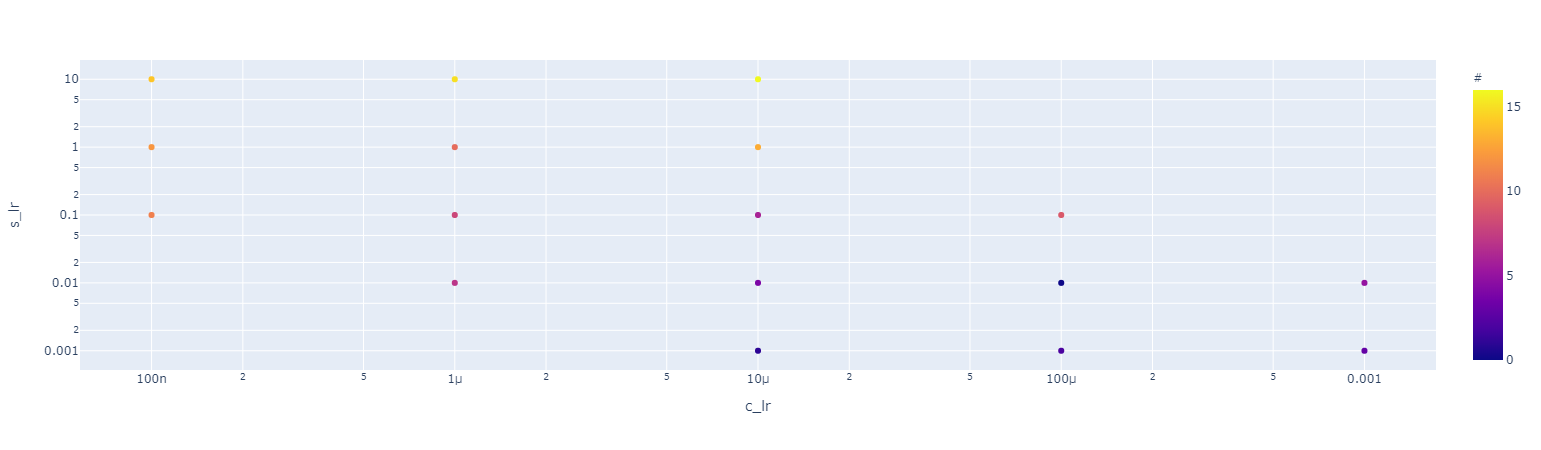

In [34]:
import plotly.express as px
df2 = pd.DataFrame({'c_lr': cs, 's_lr': ss, '#': range(len(ss))})
fig = px.scatter(df2, x="c_lr", y="s_lr", 
         color="#", log_x=True, log_y=True, size_max=60)
fig.show()

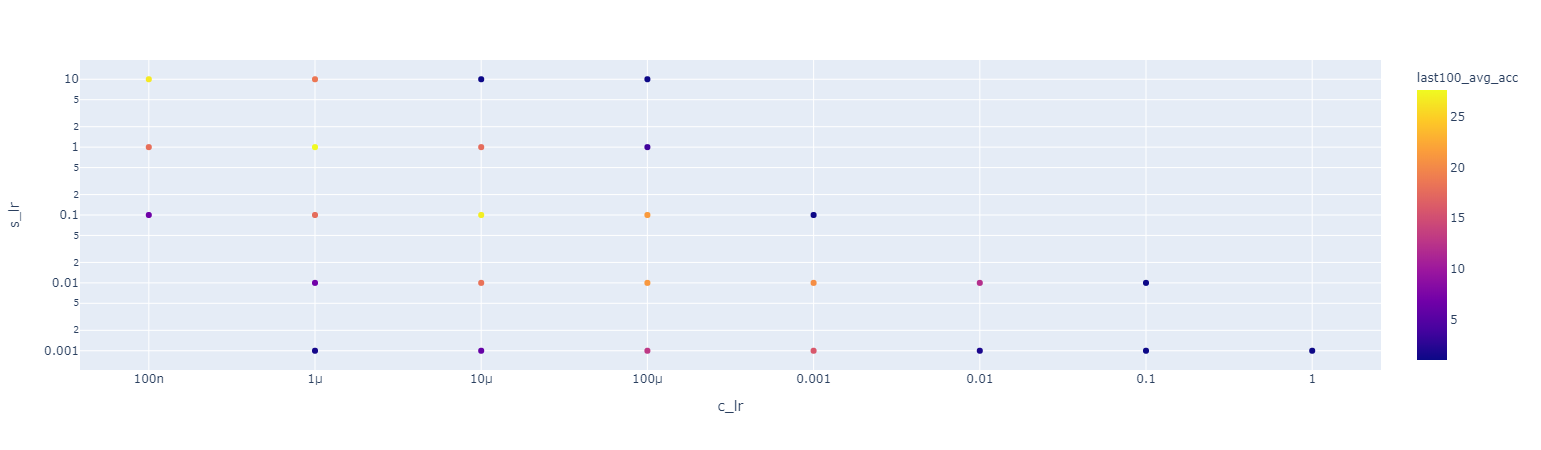

In [8]:
fig = px.scatter(df, x="c_lr", y="s_lr", 
     color="last100_avg_acc", log_x=True, log_y=True, size_max=60)
fig.show()